In [4]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
import pickle
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow import keras
# from keras.applications.vgg16 import VGG16,preprocess_input
#from keras.preprocessing.image import load_img,img_to_array
from keras.preprocessing import image

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

from keras.models import Model
from keras.utils import to_categorical,plot_model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [6]:
base_dir="/kaggle/input/flickr8k"
working_dir="/kaggle/working/"

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the Inception v3 model with pre-trained weights
model = InceptionV3(weights='imagenet')
model=Model(inputs=model.inputs,outputs=model.layers[-2].output)


96112376/96112376 [==============================] - 3s 0us/step


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
features = {}
directory = os.path.join(base_dir, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(299, 299))  # Use target_size=(299, 299) for Inception V3
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for Inception V3
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [12]:
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'), 'wb'))

In [ ]:
# features_path = os.path.join(working_dir, 'features.pkl')
# with open(features_path, 'rb') as file:
#     features = pickle.load(file)

In [13]:
with open(os.path.join(base_dir, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [15]:
# captions_doc

In [16]:
mapping = {}
# process lines
for line in captions_doc.split('\n'):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

In [17]:
mapping[list(mapping.keys())[0]]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [18]:
len(mapping)

8091

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            #caption = " ".join([word for word in caption.split() if len(word)>1])
            #caption = caption.capitalize()
            captions[i] = caption
            #caption = caption.capitalize()


In [20]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [21]:
clean(mapping)

In [22]:
all_captions=[]
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [23]:
#tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [24]:
vocab_size

8485

In [25]:
#get maximum length of the caption available
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

In [26]:
image_ids=list(mapping.keys())
split=int(len(image_ids)* .90)
split

7281

In [27]:
train=image_ids[:split]
test=image_ids[split:]

In [28]:
# create data genretor
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

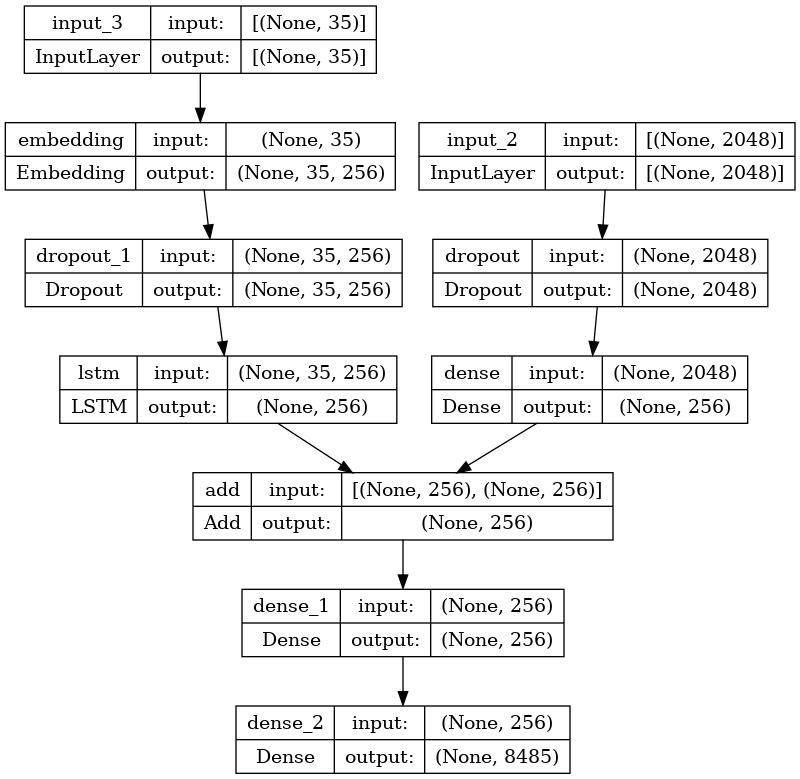

In [29]:
#encoder model
inputs1=Input(shape=(2048,))
fe1=Dropout(.4)(inputs1)
fe2=Dense(256,activation="relu")(fe1)

#sequence feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)
#seqeunce feature layers
decoder1=add([fe2,se3])
decoder2=Dense(256,activation="relu")(decoder1)
outputs=Dense(vocab_size,activation="softmax")(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#plot the model
plot_model(model,show_shapes=True)


In [30]:
epochs = 40
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    #model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 66s 288ms/step - loss: 1.8812 - accuracy: 0.5012


In [31]:
model.save("best_mode_inception_40.h5")

In [32]:
import pickle
# saving
with open('tokenizer40.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open('tokenizer40.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat,tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text      #  ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',


In [35]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.545291
BLEU-2: 0.323035


In [38]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [45]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq child in blue shirt is sitting on the ground reading book endseq


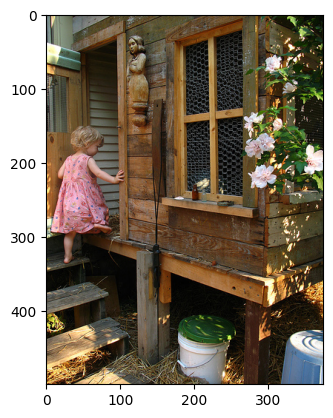

In [48]:
generate_caption("1000268201_693b08cb0e.jpg")